nodes:  50 links  69
Generation 0: Min Fitness 353340.98320641933
Generation 1: Min Fitness 348475.1138591403
Generation 2: Min Fitness 340300.5437129185
Generation 3: Min Fitness 324268.4931999031
Generation 4: Min Fitness 340300.5437129185
Generation 5: Min Fitness 331338.08972835005
Generation 6: Min Fitness 314675.2249736687
Generation 7: Min Fitness 323274.1120073383
Generation 8: Min Fitness 286202.3534038284
Generation 9: Min Fitness 286202.3534038284
Generation 10: Min Fitness 286202.3534038284
Generation 11: Min Fitness 261970.40510988148
Generation 12: Min Fitness 251160.30351005765
Generation 13: Min Fitness 251160.30351005765
Generation 14: Min Fitness 246934.747942164
Generation 15: Min Fitness 246934.747942164
Generation 16: Min Fitness 246122.36242727033
Generation 17: Min Fitness 238000.95228151348
Generation 18: Min Fitness 234814.17384980837
Generation 19: Min Fitness 223908.9970264903
Generation 20: Min Fitness 225138.53896427472
Generation 21: Min Fitness 218718.976

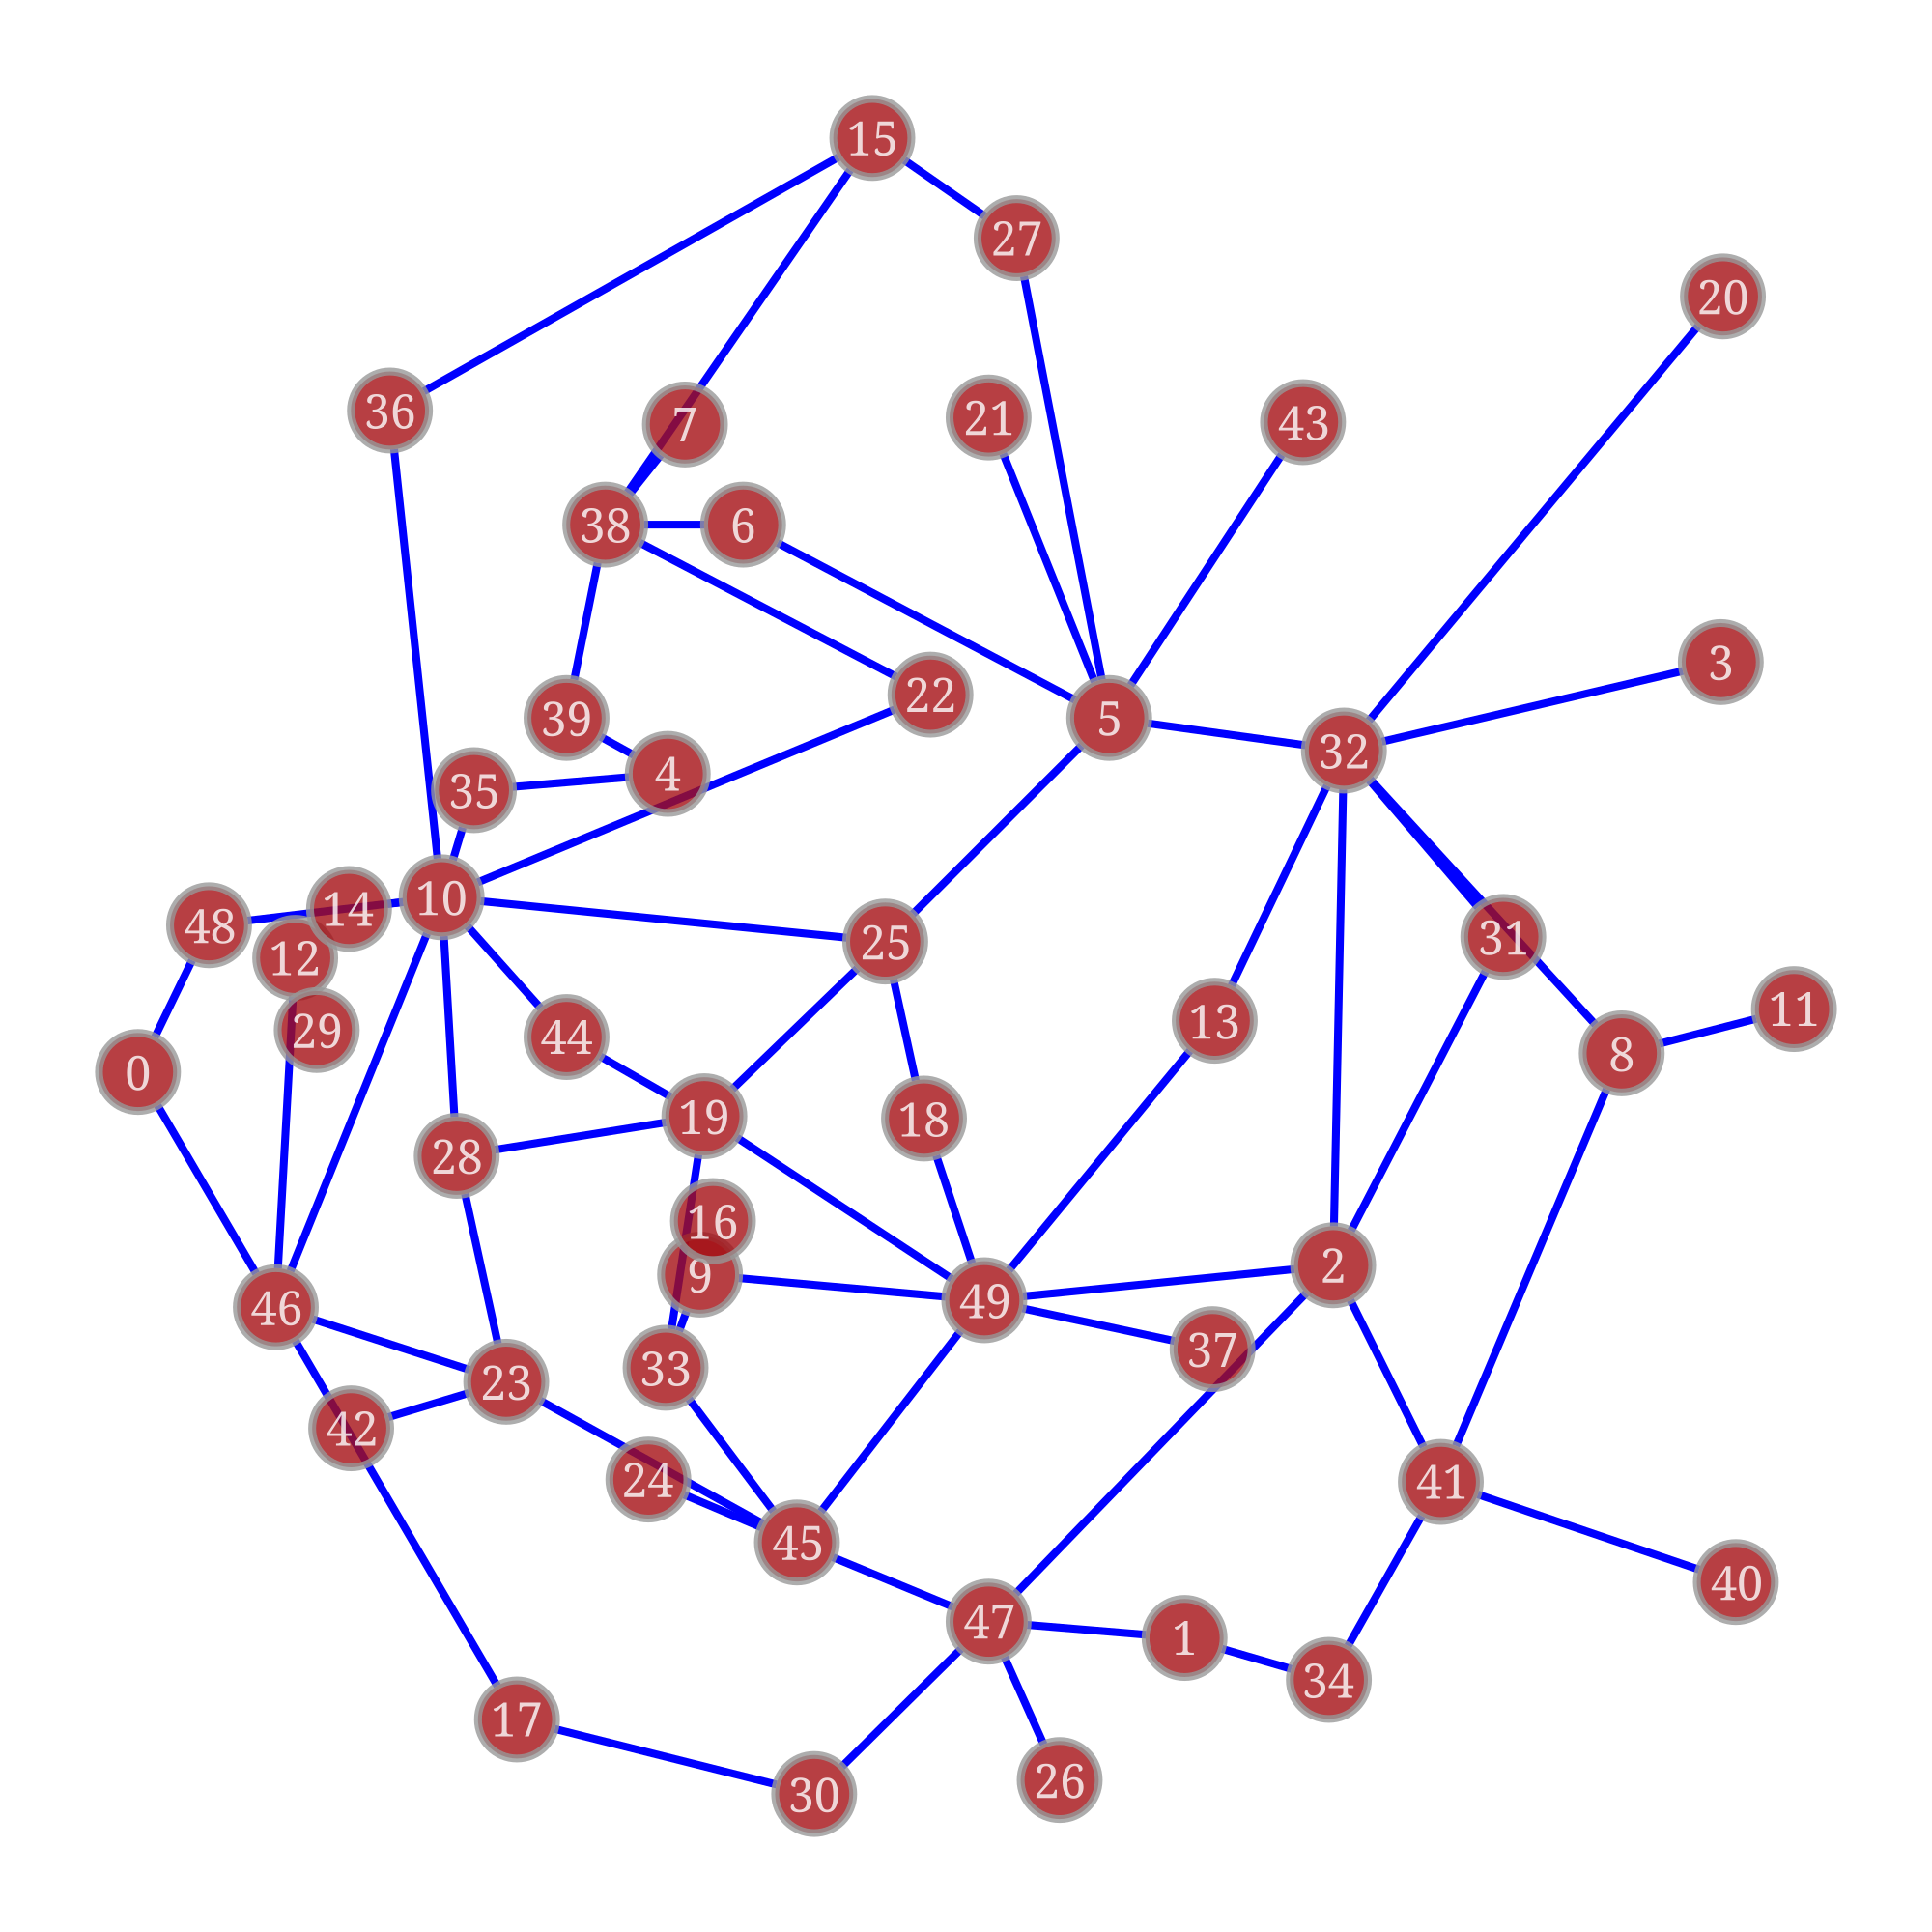

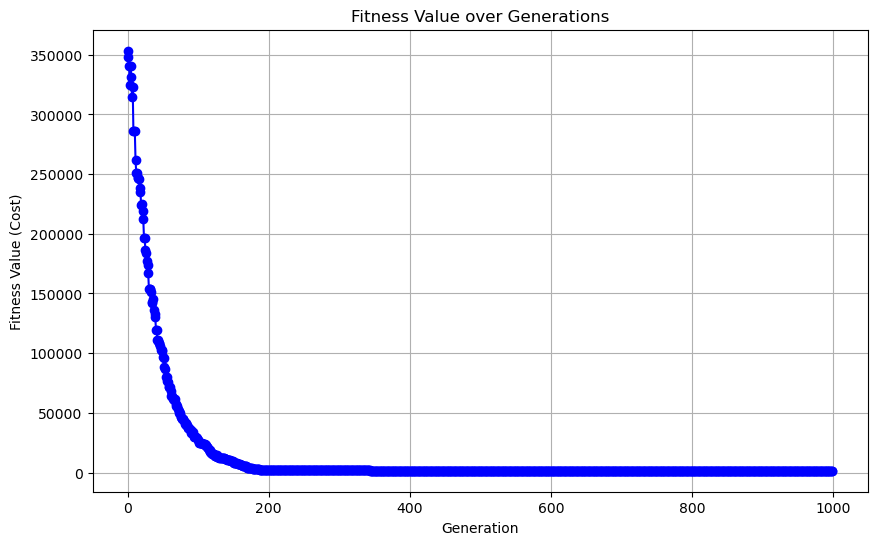

In [5]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import python_codes.graph_utilities as gu
import matplotlib.pyplot as plt
from scoop import futures

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

num_vertices = read_graph.num_vertices()
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", gu.initIndividual, read_graph)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", gu.evaluate, num_vertices=num_vertices, read_pos=read_pos, read_graph=read_graph)
toolbox.register("mate", gu.cxGraph, num_vertices=num_vertices, read_graph=read_graph)
toolbox.register("mutate", gu.mutGraph, num_vertices=num_vertices)
toolbox.register("select", tools.selTournament, tournsize=3)

# 使用scoop进行并行计算
toolbox.register("map", futures.map)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(1000):
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof, verbose=False)
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

    return pop, logbook, hof


if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = gu.individual_to_graph(best_individual, num_vertices, read_pos)

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))

    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.savefig("fitness_over_generations.png")
    plt.show()
